In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## **Reading Data**

In [2]:
data = pd.read_csv(
    '/kaggle/input/bbcnewsarchive/bbc-news-data.csv',
    sep='\t',          
    quotechar='"',
    on_bad_lines='skip'
)
data.head(5)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


## **Dataset info**

In [3]:
data.shape

(2225, 4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   filename  2225 non-null   object
 2   title     2225 non-null   object
 3   content   2225 non-null   object
dtypes: object(4)
memory usage: 69.7+ KB


## **Class Distribution**

In [5]:
data['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [6]:
category_counts = data['category'].value_counts()
print(category_counts.values)
print(category_counts.index)

[511 510 417 401 386]
Index(['sport', 'business', 'politics', 'tech', 'entertainment'], dtype='object', name='category')


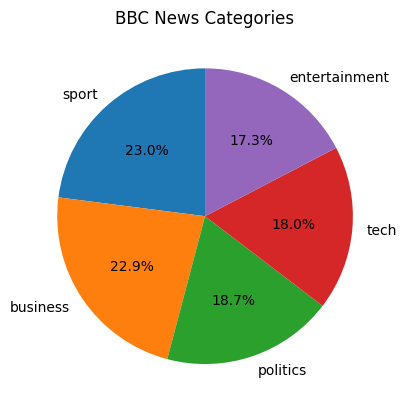

In [7]:
plt.figure()
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('BBC News Categories')
plt.show()

**Data is considered balanced**

## **Data Preprocessing**

In [3]:
##remove unimportant columns
data = data.drop(columns=['filename','title'])
data.head(5)

,category,content
0,business,Quarterly profits at US media giant TimeWarne...
1,business,The dollar has hit its highest level against ...
2,business,The owners of embattled Russian oil giant Yuk...
3,business,British Airways has blamed high fuel prices f...
4,business,Shares in UK drinks and food firm Allied Dome...


### lower case

In [4]:
data['content'] = data['content'].str.lower()
data.head(5)

,category,content
0,business,quarterly profits at us media giant timewarne...
1,business,the dollar has hit its highest level against ...
2,business,the owners of embattled russian oil giant yuk...
3,business,british airways has blamed high fuel prices f...
4,business,shares in uk drinks and food firm allied dome...


### removing panctuation marks

In [5]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [6]:
##removing panctuation marks
import string

data['content'] = data['content'].apply(
    lambda text: ''.join(ch for ch in text if ch not in string.punctuation)
)

### removing unwanted characters

In [7]:
##removing unwanted characters
import re

url_re = re.compile(r'https?://\S+|www\.\S+')
username_re = re.compile(r'@\w+')
hashtag_re = re.compile(r'#\w+')

def remove_unwanted_chars(text):
    text = re.sub(url_re, '', text)
    text = re.sub(username_re, '', text)
    text = re.sub(hashtag_re, '', text)

    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [8]:
data['content'] = data['content'].apply(remove_unwanted_chars)

### removing stop words

In [9]:
##removing stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

data['content'] = data['content'].apply(
    lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

data.head(5)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,category,content
0,business,quarterly profits us media giant timewarner ju...
1,business,dollar hit highest level euro almost three mon...
2,business,owners embattled russian oil giant yukos ask b...
3,business,british airways blamed high fuel prices 40 dro...
4,business,shares uk drinks food firm allied domecq risen...


## **Label encoder**

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(data['category'])

In [11]:
y

array([0, 0, 0, ..., 4, 4, 4])

## **Data Embeddings**

### **1- tf-idf with NB model**

In [17]:
##vectorization

from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vectorization = TfidfVectorizer()
tfidf_vectorized = tf_idf_vectorization.fit_transform(data['content'])

In [18]:
##train-test split
from sklearn.model_selection import train_test_split
x_traintfidf, x_testtfidf, y_train, y_test = train_test_split(tfidf_vectorized,y, test_size= 0.2, random_state=0)
print(f"Train: {x_traintfidf.shape} \t {y_train.shape} \n Test: {x_testtfidf.shape} \t {y_test.shape}")

Train: (1780, 33893) 	 (1780,) 
 Test: (445, 33893) 	 (445,)


In [19]:
##Naive bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import  confusion_matrix, accuracy_score

NB_modelTFIDF = MultinomialNB()
NB_modelTFIDF.fit(x_traintfidf, y_train)
NB_predTFIDF = NB_modelTFIDF.predict(x_testtfidf)
print("Naive Bayes Accuracy for TFIDF vectorization:", accuracy_score(y_test, NB_predTFIDF))

Naive Bayes Accuracy for TFIDF vectorization: 0.9707865168539326


### **2- LSTM with learned embeddings from zero**

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

##convert tokens to its corresponding ids
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["content"])
print("Vocabulary (Word → ID):", tokenizer.word_index)

Vocabulary (Word → ID): {'said': 1, 'mr': 2, 'would': 3, 'also': 4, 'people': 5, 'new': 6, 'us': 7, 'one': 8, 'year': 9, 'could': 10, 'last': 11, 'first': 12, 'years': 13, 'two': 14, 'time': 15, 'government': 16, 'world': 17, 'best': 18, 'make': 19, 'told': 20, 'uk': 21, 'get': 22, 'made': 23, 'like': 24, 'many': 25, 'game': 26, 'music': 27, 'film': 28, 'next': 29, 'three': 30, 'number': 31, 'back': 32, 'well': 33, 'added': 34, 'way': 35, 'take': 36, 'bbc': 37, 'set': 38, 'may': 39, 'says': 40, 'market': 41, 'good': 42, 'home': 43, 'labour': 44, 'games': 45, 'going': 46, 'still': 47, '2004': 48, 'company': 49, 'much': 50, 'since': 51, 'work': 52, 'election': 53, 'go': 54, 'think': 55, 'use': 56, 'say': 57, 'win': 58, 'million': 59, 'part': 60, 'play': 61, 'want': 62, 'public': 63, 'technology': 64, 'second': 65, 'see': 66, 'show': 67, 'firm': 68, 'week': 69, 'british': 70, 'used': 71, 'england': 72, 'top': 73, 'players': 74, 'party': 75, 'however': 76, 'news': 77, 'minister': 78, 'euro

In [13]:
##convert each list of tokens to its corresponding sequence of IDs
sequences = tokenizer.texts_to_sequences(data["content"])
print(sequences[5])

[1739, 110, 15599, 6403, 1339, 3321, 30, 84, 525, 176, 67, 3322, 176, 2677, 95, 3966, 20985, 8057, 443, 387, 512, 1496, 178, 1028, 512, 95, 4434, 2870, 50, 20986, 1149, 859, 275, 1218, 1339, 4848, 3321, 14, 3563, 2953, 3143, 95, 16, 949, 61, 2871, 4119, 178, 2491, 710, 1739, 110, 756, 4849, 12938, 5660, 4276, 6847, 1874, 3669, 2605, 1, 110, 78, 11073, 8802, 318, 6848, 1710, 207, 985, 230, 1827, 12939, 6404, 129, 1389, 283, 3323, 230, 15584, 6405, 1007, 1149, 50, 20987, 859, 275, 1, 591, 20988, 1340, 15600, 3144, 4646, 3233, 358, 41, 3670, 293, 6849, 920, 396, 694, 3049, 4434, 143, 387]


In [14]:
##apply padding for fixed input size
padded_sequences = pad_sequences(sequences, maxlen=500, padding="post", truncating="post")
print(padded_sequences[6])

[    7   782  2606   370    82   211   566 15601  1802  1268   339  2263
   420    30    13   106  5994   753   176     7   100    34 15602   370
   211  1711 15603 11074    41  1387 15604     6   370  4647   330  1688
  1268   339  2726  2263   420    51   525   455   358  2792   517   189
  1090  4648  5661  1712  4277   123    95   370     7   110    12   763
   184 15605   123   566   370    11  7408  3324    53    12   189    51
  9765 15606   368   358  2306   729   314   279    11    13    53    76
  1121   224  5662   176  7409    12   763   370   125  1280   840  4278
  5994   753     4     1  3322   370  2792   224    48 11075 11076   231
     1    95     6   370   288    10    82   190  6850   129  1389  1028
  1803  1321  3431  5663  1497     1  4850 15607  1435    98  1340 15608
   271    91   334   636  1803     3   136   190   492   652   366    47
  2175   492   245   339  1341   110  2127  5663  8058   749   358    95
     1  2872 12940   189 12941  2678   354  1219   

In [15]:

padded_sequences.shape

(2225, 500)

In [17]:
from sklearn.model_selection import train_test_split
##train-test split
x_trainpadd, x_testpadd, y_train, y_test = train_test_split(padded_sequences,y, test_size= 0.2, random_state=0)
print(f"Train: {x_trainpadd.shape} \t {y_train.shape} \n Test: {x_testpadd.shape} \t {y_test.shape}")

Train: (1780, 500) 	 (1780,) 
 Test: (445, 500) 	 (445,)


In [23]:
##building model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, GlobalMaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


model = Sequential([
    Embedding(
        input_dim=len(tokenizer.word_index) + 1, 
        output_dim=300, 
        input_length=500,
        mask_zero=True),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4))),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(5, activation='softmax')
])

In [24]:
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [25]:
model.build(input_shape=(None, 500))
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 300)       │    10,176,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 500, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,363,825 (39.53 MB)

 Trainable params: 10,363,825 (39.53 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    x_trainpadd, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1767558731.432514     142 cuda_dnn.cc:529] Loaded cuDNN version 91002


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2524 - loss: 1.6596
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6508 - loss: 1.5989
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8673 - loss: 1.5153
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8604 - loss: 1.2134
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.8318 - loss: 0.6982
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9293 - loss: 0.5056
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9551 - loss: 0.3294
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9611 - loss: 0.2568
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9792 - loss: 0.1864
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9860 - loss: 0.1380


In [27]:
loss, accuracy = model.evaluate(x_testpadd, y_test)
print(f'Model Accuracy : {accuracy * 100}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8689 - loss: 0.5854
Model Accuracy : 87.41573095321655


In [33]:
from sklearn.metrics import accuracy_score
import numpy as np

pred = np.argmax(model.predict(x_testpadd), axis = -1)
y_test_int = np.argmax(y_test, axis=-1)

test_accuracy = accuracy_score(y_test, pred)
print(f"Test Accuracy 1: {test_accuracy * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Test Accuracy 1: 87.42%


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.94      0.87       111
           1       0.80      0.96      0.87        74
           2       0.92      0.67      0.78        86
           3       0.92      0.90      0.91       108
           4       0.98      0.89      0.94        66

    accuracy                           0.87       445
   macro avg       0.89      0.87      0.87       445
weighted avg       0.88      0.87      0.87       445



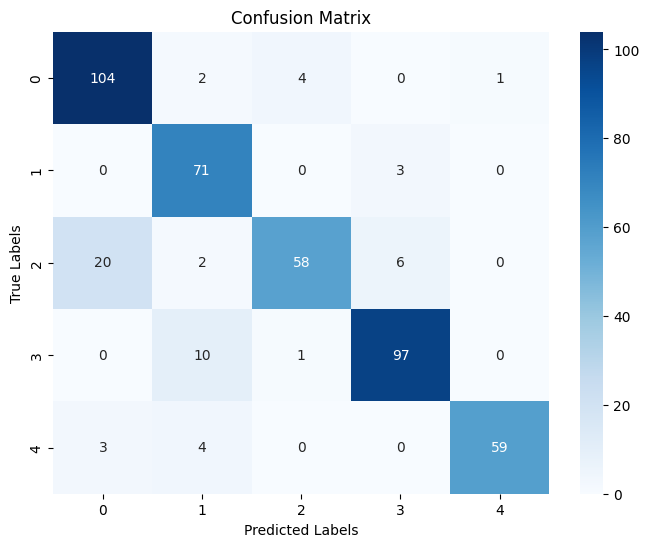

In [37]:
import seaborn as sns
cm = confusion_matrix(y_test, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### **4- LSTM with pretrained fast text embeddings**

In [38]:
from gensim.models.fasttext import load_facebook_model

model = load_facebook_model("/kaggle/input/cc-en-300-bin/cc.en.300.bin")

In [39]:
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in model.wv:
        embedding_matrix[i] = model.wv[word]

In [51]:
##building model
model_fasttext = Sequential([
    Embedding(
        input_dim=len(tokenizer.word_index) + 1, 
        output_dim=300,
        weights=[embedding_matrix], 
        trainable=False,
        input_length=500),
    Bidirectional(LSTM(100, return_sequences=True, kernel_regularizer=l2(1e-4))),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(5, activation='softmax')
])

In [54]:
model_fasttext.compile(optimizer = Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [55]:
model_fasttext.build(input_shape=(None, 500))
model_fasttext.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ (None, 500, 300)       │    10,176,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 500, 200)       │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 500, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_8          │ (None, 200)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,005 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,498,105 (40.05 MB)

 Trainable params: 321,805 (1.23 MB)

 Non-trainable params: 10,176,300 (38.82 MB)

In [56]:
history_fasttext = model_fasttext.fit(
    x_trainpadd, y_train,
    epochs=10,
    batch_size=32
)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.4080 - loss: 1.6296
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6804 - loss: 1.4535
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7480 - loss: 1.2177
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8319 - loss: 0.6699
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8848 - loss: 0.4414
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9084 - loss: 0.3607
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9365 - loss: 0.3205
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9400 - loss: 0.2781
Epoch 9/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9451 - loss: 0.2436
Epoch 10/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.9539 - loss: 0.2192


In [57]:
loss, accuracy = model_fasttext.evaluate(x_testpadd, y_test)
print(f'Model Accuracy : {accuracy * 100}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9360 - loss: 0.4316
Model Accuracy : 93.93258690834045


In [60]:
pred2 = np.argmax(model_fasttext.predict(x_testpadd), axis = -1)
y_test_int2 = np.argmax(y_test, axis=-1)

test_accuracy = accuracy_score(y_test, pred2)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Test Accuracy: 93.93%


In [61]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       111
           1       0.92      0.95      0.93        74
           2       0.93      0.91      0.92        86
           3       0.98      0.98      0.98       108
           4       0.91      0.94      0.93        66

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



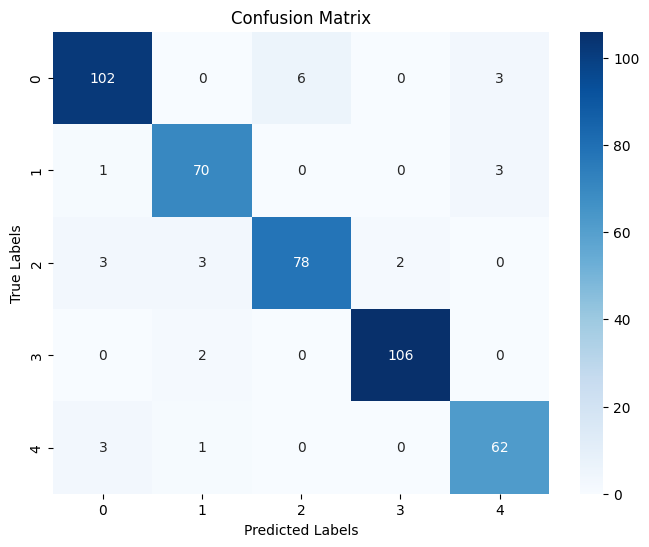

In [63]:
cm = confusion_matrix(y_test, pred2)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [66]:
model_fasttext.save("my_lstm_model.h5")